I'm working on implementing the generative model here

In [1]:
import torch
import pennylane as qml
from itertools import combinations
from time_series_utils import generate_synthetic_correlated_time_series, apply_sax, classical_transition_matrix, flatten_recursive
import matplotlib.pyplot as plt
import numpy as np

series_length = 5
n_subspace_qubits = 2
environment_qubits = n_subspace_qubits
n_qubits = series_length*n_subspace_qubits + environment_qubits
dev = qml.device("default.qubit", wires= n_qubits)
time_steps = [2,3,10,30,50]
W = qml.StronglyEntanglingLayers
W_layers = 2
h = 2

In [2]:
def D(gamma: torch.Tensor, start : int, stop : int, h: int = None, get_probs: bool = False) -> None:
    """https://doi.org/10.1088/1367-2630/16/3/033040"""
    #print(gamma)
    if h is None:
        h = stop - start
    cnt = 0
    for i in range(1, h + 1):
        for comb in combinations(range(start, stop), i):
            if len(comb) == 1:
                qml.RZ(gamma[cnt], wires=[comb[0]])
                cnt += 1
            elif len(comb) > 1:
                cnots = [comb[i : i + 2] for i in range(len(comb) - 1)]
                for j in cnots:
                    qml.CNOT(wires=j)
                qml.RZ(gamma[cnt], wires=[comb[-1]])
                cnt += 1
                for j in cnots[::-1]:
                    qml.CNOT(wires=j)
    if get_probs:
        return qml.probs(wires=range(start, stop))

In [3]:
# Now X = (s_1, ..., s_m) where each s_i is a discrete time series
# Depending on the discretization, we use x subspace qubits to encode space H_s_i
@qml.qnode(dev, interface="torch", diff_method="backprop")
def circuit(
    X: torch.Tensor,
    time_step: float,
    n_subspace_qubits: int,
    environment_qubits: int,
    projected_subspace,
    alpha: torch.Tensor,
    gamma: torch.Tensor,
    h: int,
    W: callable,
    D: callable,
    n_qubits: int,
    measurement: str
) -> torch.Tensor:
    # Depending on the dimensionality of the input, 
    # we need to embed the time series data
    # into different subspaces
    for i, point in enumerate(X):
        subspace = range(i*n_subspace_qubits, (i + 1)*n_subspace_qubits)
        #point = [x[0] for x in point] 
        qml.BasisEmbedding(point, wires=subspace)
    
        # These gates operate h-locally
        # This means that each time series component corresponding
        # a subspsace H_s_d is evolved with its own decomposition WDW^t
    
        W(alpha, wires=subspace)
        D(gamma * time_step, i*n_subspace_qubits, (i + 1)*n_subspace_qubits, h)
        qml.adjoint(W)(alpha, wires=subspace)
    
    # Finally, create environment subspace
    e_subspace = range(n_qubits - environment_qubits, n_qubits)
    W(alpha, wires=e_subspace)
    D(gamma * time_step, n_qubits - environment_qubits, n_qubits, h)
    qml.adjoint(W)(alpha, wires=e_subspace)
    
    return qml.probs(wires = projected_subspace)

In [6]:
def get_initial_parameters(W, W_layers, n_subspace_qubits, seed = 0):
    torch.manual_seed(seed)
    init_alpha = torch.rand(W.shape(W_layers, n_subspace_qubits))
    init_gamma = torch.rand(n_subspace_qubits + 1) # Why the gate D requires gamma be at least this much in the multi-dimensional case
    init_params = {
        "alpha": (2 * torch.pi * init_alpha).clone().detach().requires_grad_(True),
        "gamma": (2 * torch.pi * init_gamma).clone().detach().requires_grad_(True),
    }
    return init_params

In [7]:
kl_loss = torch.nn.KLDivLoss(reduction="batchmean")

def loss_function(time_step, X, alpha, gamma, classical_transition_matrices):
    loss = torch.tensor(0.0, requires_grad=True)
    #print("X in loss function: ", X)
    # Zip the corresponding segments in each dimension together
    for Xi in zip(*X):
        #print("Xi: ", Xi)
        for (segment1, segment2) in zip(Xi, Xi[1:]):
            #print("Segment: ", segment1)
            # I don't know how to get probs for subspace without explicitly specifying the subspace
            for j in range(len(segment1)):
                subspace = range(n_subspace_qubits*j, n_subspace_qubits*(j + 1))
                probs = circuit(segment1, time_step, n_subspace_qubits, environment_qubits, subspace, alpha, gamma, h, W, D, n_qubits, measurement = "probs")
                #print("Probs: ", probs)
                #print("Classical distribution", classical_transition_matrices[time_step][segment2[j]])
                loss = loss + kl_loss(probs, classical_transition_matrices[time_step][segment2[j]]) #KL_divergence(classical_transition_matrices[time_step][segment2[j]], probs) #total_KL_divergence(X, classical_transition_matrices[time_step][segment2[j]], probs)
    return loss

In [8]:
def train_model(
    lr: float,
    init_params: dict,
    pytorch_optimizer: callable,
    cycler,
    batch_iterations: int,
    classical_transition_matrices,
    seed=0,
    print_intermediate=True,
) -> dict:
    torch.manual_seed(seed)
    opt = pytorch_optimizer(init_params.values(), lr=lr)
    alpha = init_params["alpha"]
    gamma = init_params["gamma"]

    def closure():
        opt.zero_grad()
        # Iterate over the time steps
        for i, X in enumerate(cycler):
            loss = loss_function(i, X, alpha, gamma, classical_transition_matrices)
            loss.backward()
        return loss

    loss_history = []
    for i in range(batch_iterations):
        loss = opt.step(closure)
        loss_history.append(loss.item())
        if batch_iterations % 10 == 0 and print_intermediate:
            print(f"Iteration number {i}\n Current loss {loss.item()}\n")

    results_dict = {
        "opt_params": {
            "alpha": opt.param_groups[0]["params"][0],
            "gamma": opt.param_groups[0]["params"][1]
        },
        "loss_history": loss_history,
    }
    return results_dict

In [9]:
T = 200
N = 100
X = generate_synthetic_correlated_time_series(T, N)
X_d = {}
X_discrete_d = []
classical_transition_matrices = []
for time_step in time_steps:
    X_d[time_step] = [x[:time_step] for x in X]
    discrete_X, time_series_sax = apply_sax(X_d[time_step], n_sax_symbols = 2**n_subspace_qubits)
    #print(discrete_X)
    X_discrete_d.append([list(flatten_recursive(x)) for x in time_series_sax])
    #print(X_discrete_d[time_step])
    classical_matrix = torch.Tensor(classical_transition_matrix(list(flatten_recursive(time_series_sax)))).clone().detach().requires_grad_(True)
    #print("Classical matrix: ", classical_matrix)
    classical_transition_matrices.append(classical_matrix)
    
#print(X_d)
#print(X_discrete_d)
#print(classical_transition_matrices)
init_params = get_initial_parameters(W, W_layers, n_subspace_qubits)
cycler = torch.utils.data.DataLoader(X_discrete_d, batch_size=1, shuffle=False)
lr = 0.01
pytorch_optimizer = torch.optim.Adam
batch_iterations = 50
result = train_model(lr, init_params, pytorch_optimizer, cycler, batch_iterations, classical_transition_matrices)
print(result)


c:\Users\valte\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\piecewise\piecewise.py:152: RuntimeWarning: Mean of empty slice.
  X_transformed[i_ts, i_seg, :] = segment.mean(axis=0)
c:\Users\valte\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\valte\AppData\Local\Programs\Python\Python310\lib\site-packages\tslearn\piecewise\piecewise.py:152: RuntimeWarning: Mean of empty slice.
  X_transformed[i_ts, i_seg, :] = segment.mean(axis=0)
c:\Users\valte\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Iteration number 0
 Current loss -0.4984085041769399

Iteration number 1
 Current loss -0.5038891551703761

Iteration number 2
 Current loss -0.5096469354632107

Iteration number 3
 Current loss -0.5156183795570276

Iteration number 4
 Current loss -0.5217264218764885

Iteration number 5
 Current loss -0.527890830385547

Iteration number 6
 Current loss -0.5340302753207675

Iteration number 7
 Current loss -0.5400647660853926

Iteration number 8
 Current loss -0.5459187278120963

Iteration number 9
 Current loss -0.5515245050776147

Iteration number 10
 Current loss -0.5568260716581289

Iteration number 11
 Current loss -0.5617826382941047

Iteration number 12
 Current loss -0.5663717691695395

Iteration number 13
 Current loss -0.5705916198671216

Iteration number 14
 Current loss -0.5744620279863641

Iteration number 15
 Current loss -0.5780243569989725

Iteration number 16
 Current loss -0.5813400781961144

Iteration number 17
 Current loss -0.5844880154655374

Iteration number 18
 

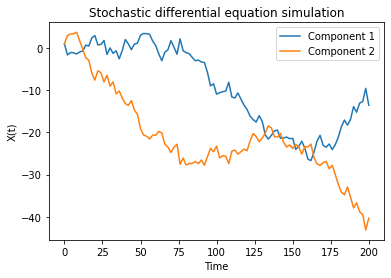

In [10]:
time = np.linspace(0, T, N + 1)
for i in range(2):
    plt.plot(time, X[i], label=f'Component {i+1}')
plt.xlabel('Time')
plt.ylabel('X(t)')
plt.title('Stochastic differential equation simulation')
plt.legend()
plt.show()